<a href="https://colab.research.google.com/github/MengOonLee/BertelsmannAITrack/blob/master/Recurrent_neural_network/Project/TV_script_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TV Script Generation

In this project, you'll generate your own [Seinfeld](https://en.wikipedia.org/wiki/Seinfeld) TV scripts using RNNs.  You'll be using part of the [Seinfeld dataset](https://www.kaggle.com/thec03u5/seinfeld-chronicles#scripts.csv) of scripts from 9 seasons.  The Neural Network you'll build will generate a new ,"fake" TV script, based on patterns it recognizes in this training data.

## Get the Data

The data is already provided for you in `./data/Seinfeld_Scripts.txt` and you're encouraged to open that file and look at the text. 
>* As a first step, we'll load in this data and look at some samples. 
* Then, you'll be tasked with defining and training an RNN to generate a new script!

In [1]:
import os

if not os.path.exists('./data'):
  os.makedirs('./data')

!wget -qO ./data/Seinfeld_Scripts.txt "https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/project-tv-script-generation/data/Seinfeld_Scripts.txt"

In [2]:
%%file ./helper.py

import os
import pickle
import torch


SPECIAL_WORDS = {'PADDING': '<PAD>'}


def load_data(path):
    """
    Load Dataset from File
    """
    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()

    return data


def preprocess_and_save_data(dataset_path, token_lookup, create_lookup_tables):
    """
    Preprocess Text Data
    """
    text = load_data(dataset_path)
    
    # Ignore notice, since we don't use it for analysing the data
    text = text[81:]

    token_dict = token_lookup()
    for key, token in token_dict.items():
        text = text.replace(key, ' {} '.format(token))

    text = text.lower()
    text = text.split()

    vocab_to_int, int_to_vocab = create_lookup_tables(text + list(SPECIAL_WORDS.values()))
    int_text = [vocab_to_int[word] for word in text]
    pickle.dump((int_text, vocab_to_int, int_to_vocab, token_dict), open('preprocess.p', 'wb'))


def load_preprocess():
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    return pickle.load(open('preprocess.p', mode='rb'))


def save_model(filename, decoder):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(decoder, save_filename)


def load_model(filename):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    return torch.load(save_filename)

Overwriting ./helper.py


In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# load in data
import helper
data_dir = './data/Seinfeld_Scripts.txt'
text = helper.load_data(data_dir)

## Explore the Data
Play around with `view_line_range` to view different parts of the data. This will give you a sense of the data you'll be working with. You can see, for example, that it is all lowercase text, and each new line of dialogue is separated by a newline character `\n`.

In [4]:
view_line_range = (0, 10)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in text.split()})))

lines = text.split('\n')
print('Number of lines: {}'.format(len(lines)))
word_count_line = [len(line.split()) for line in lines]
print('Average number of words in each line: {}'.format(np.average(word_count_line)))

print()
print('The lines {} to {}:'.format(*view_line_range))
print('\n'.join(text.split('\n')[view_line_range[0]:view_line_range[1]]))

Dataset Stats
Roughly the number of unique words: 46367
Number of lines: 109233
Average number of words in each line: 5.544240293684143

The lines 0 to 10:
jerry: do you know what this is all about? do you know, why were here? to be out, this is out...and out is one of the single most enjoyable experiences of life. people...did you ever hear people talking about we should go out? this is what theyre talking about...this whole thing, were all out now, no one is home. not one person here is home, were all out! there are people trying to find us, they dont know where we are. (on an imaginary phone) did you ring?, i cant find him. where did he go? he didnt tell me where he was going. he must have gone out. you wanna go out you get ready, you pick out the clothes, right? you take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...then youre standing around, what do you do? you go we gotta be getting back. once youre out, you wanna get back! y

In [5]:
%%file ./problem_unittests.py

from unittest.mock import MagicMock, patch
import numpy as np
import torch


class _TestNN(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(_TestNN, self).__init__()
        self.decoder = torch.nn.Linear(input_size, output_size)
        self.forward_called = False
    
    def forward(self, nn_input, hidden):
        self.forward_called = True
        output = self.decoder(nn_input)
        
        return output, hidden


def _print_success_message():
    print('Tests Passed')


class AssertTest(object):
    def __init__(self, params):
        self.assert_param_message = '\n'.join([str(k) + ': ' + str(v) + '' for k, v in params.items()])
    
    def test(self, assert_condition, assert_message):
        assert assert_condition, assert_message + '\n\nUnit Test Function Parameters\n' + self.assert_param_message


def test_create_lookup_tables(create_lookup_tables):
    test_text = '''
        Moe_Szyslak Moe's Tavern Where the elite meet to drink
        Bart_Simpson Eh yeah hello is Mike there Last name Rotch
        Moe_Szyslak Hold on I'll check Mike Rotch Mike Rotch Hey has anybody seen Mike Rotch lately
        Moe_Szyslak Listen you little puke One of these days I'm gonna catch you and I'm gonna carve my name on your back with an ice pick
        Moe_Szyslak Whats the matter Homer You're not your normal effervescent self
        Homer_Simpson I got my problems Moe Give me another one
        Moe_Szyslak Homer hey you should not drink to forget your problems
        Barney_Gumble Yeah you should only drink to enhance your social skills'''
    
    test_text = test_text.lower()
    test_text = test_text.split()
    
    vocab_to_int, int_to_vocab = create_lookup_tables(test_text)
    
    # Check types
    assert isinstance(vocab_to_int, dict),\
        'vocab_to_int is not a dictionary.'
    assert isinstance(int_to_vocab, dict),\
        'int_to_vocab is not a dictionary.'
    
    # Compare lengths of dicts
    assert len(vocab_to_int) == len(int_to_vocab),\
        'Length of vocab_to_int and int_to_vocab don\'t match. ' \
        'vocab_to_int is length {}. int_to_vocab is length {}'.format(len(vocab_to_int), len(int_to_vocab))

    # Make sure the dicts have the same words
    vocab_to_int_word_set = set(vocab_to_int.keys())
    int_to_vocab_word_set = set(int_to_vocab.values())

    assert not (vocab_to_int_word_set - int_to_vocab_word_set),\
    'vocab_to_int and int_to_vocab don\'t have the same words.' \
        '{} found in vocab_to_int, but not in int_to_vocab'.format(vocab_to_int_word_set - int_to_vocab_word_set)
    assert not (int_to_vocab_word_set - vocab_to_int_word_set),\
        'vocab_to_int and int_to_vocab don\'t have the same words.' \
        '{} found in int_to_vocab, but not in vocab_to_int'.format(int_to_vocab_word_set - vocab_to_int_word_set)
    
    # Make sure the dicts have the same word ids
    vocab_to_int_word_id_set = set(vocab_to_int.values())
    int_to_vocab_word_id_set = set(int_to_vocab.keys())
    
    assert not (vocab_to_int_word_id_set - int_to_vocab_word_id_set),\
        'vocab_to_int and int_to_vocab don\'t contain the same word ids.' \
        '{} found in vocab_to_int, but not in int_to_vocab'.format(vocab_to_int_word_id_set - int_to_vocab_word_id_set)
    assert not (int_to_vocab_word_id_set - vocab_to_int_word_id_set),\
        'vocab_to_int and int_to_vocab don\'t contain the same word ids.' \
        '{} found in int_to_vocab, but not in vocab_to_int'.format(int_to_vocab_word_id_set - vocab_to_int_word_id_set)
    
    # Make sure the dicts make the same lookup
    missmatches = [(word, id, id, int_to_vocab[id]) for word, id in vocab_to_int.items() if int_to_vocab[id] != word]
    
    assert not missmatches,\
        'Found {} missmatche(s). First missmatch: vocab_to_int[{}] = {} and int_to_vocab[{}] = {}'.format(len(missmatches),
                                                                                                          *missmatches[0])
    
    assert len(vocab_to_int) > len(set(test_text))/2,\
        'The length of vocab seems too small.  Found a length of {}'.format(len(vocab_to_int))
    
    _print_success_message()


def test_tokenize(token_lookup):
    symbols = set(['.', ',', '"', ';', '!', '?', '(', ')', '-', '\n'])
    token_dict = token_lookup()
    
    # Check type
    assert isinstance(token_dict, dict), \
        'Returned type is {}.'.format(type(token_dict))

    # Check symbols
    missing_symbols = symbols - set(token_dict.keys())
    unknown_symbols = set(token_dict.keys()) - symbols

    assert not missing_symbols, \
    'Missing symbols: {}'.format(missing_symbols)
    assert not unknown_symbols, \
        'Unknown symbols: {}'.format(unknown_symbols)

    # Check values type
    bad_value_type = [type(val) for val in token_dict.values() if not isinstance(val, str)]
    
    assert not bad_value_type,\
        'Found token as {} type.'.format(bad_value_type[0])

    # Check for spaces
    key_has_spaces = [k for k in token_dict.keys() if ' ' in k]
    val_has_spaces = [val for val in token_dict.values() if ' ' in val]
    
    assert not key_has_spaces,\
        'The key "{}" includes spaces. Remove spaces from keys and values'.format(key_has_spaces[0])
    assert not val_has_spaces,\
    'The value "{}" includes spaces. Remove spaces from keys and values'.format(val_has_spaces[0])
    
    # Check for symbols in values
    symbol_val = ()
    for symbol in symbols:
        for val in token_dict.values():
            if symbol in val:
                symbol_val = (symbol, val)

    assert not symbol_val,\
    'Don\'t use a symbol that will be replaced in your tokens. Found the symbol {} in value {}'.format(*symbol_val)
    
    _print_success_message()


def test_rnn(RNN, train_on_gpu):
    batch_size = 50
    sequence_length = 3
    vocab_size = 20
    output_size=20
    embedding_dim=15
    hidden_dim = 10
    n_layers = 2
    
    # create test RNN
    # params: (vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
    rnn = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
    
    # create test input
    a = np.random.randint(vocab_size, size=(batch_size, sequence_length))
    #b = torch.LongTensor(a)
    b = torch.from_numpy(a)
    hidden = rnn.init_hidden(batch_size)
    
    if(train_on_gpu):
        rnn.cuda()
        b = b.cuda()
    
    output, hidden_out = rnn(b, hidden)
    
    assert_test = AssertTest({
                             'Input Size': vocab_size,
                             'Output Size': output_size,
                             'Hidden Dim': hidden_dim,
                             'N Layers': n_layers,
                             'Batch Size': batch_size,
                             'Sequence Length': sequence_length,
                             'Input': b})
    
    # initialization
    correct_hidden_size = (n_layers, batch_size, hidden_dim)
    
    if type(hidden) == tuple:
        # LSTM
        assert_condition = hidden[0].size() == correct_hidden_size
    else:
        # GRU
        assert_condition = hidden.size() == correct_hidden_size

    assert_message = 'Wrong hidden state size. Expected type {}. Got type {}'.format(correct_hidden_size, hidden[0].size())
    assert_test.test(assert_condition, assert_message)
    
    # output of rnn
    correct_hidden_size = (n_layers, batch_size, hidden_dim)
    
    if type(hidden) == tuple:
        # LSTM        
        assert_condition = hidden_out[0].size() == correct_hidden_size
    else:
        # GRU
        assert_condition = hidden_out.size() == correct_hidden_size

    assert_message = 'Wrong hidden state size. Expected type {}. Got type {}'.format(correct_hidden_size, hidden_out[0].size())
    assert_test.test(assert_condition, assert_message)
    
    correct_output_size = (batch_size, output_size)
    assert_condition = output.size() == correct_output_size
    assert_message = 'Wrong output size. Expected type {}. Got type {}'.format(correct_output_size, output.size())
    assert_test.test(assert_condition, assert_message)
    
    _print_success_message()


def test_forward_back_prop(RNN, forward_back_prop, train_on_gpu):
    batch_size = 200
    input_size = 20
    output_size = 10
    sequence_length = 3
    embedding_dim=15
    hidden_dim = 10
    n_layers = 2
    learning_rate = 0.01
    
    # create test RNN
    rnn = RNN(input_size, output_size, embedding_dim, hidden_dim, n_layers)
    
    mock_decoder = MagicMock(wraps=_TestNN(input_size, output_size))
    if train_on_gpu:
        mock_decoder.cuda()
    
    mock_decoder_optimizer = MagicMock(wraps=torch.optim.Adam(mock_decoder.parameters(), lr=learning_rate))
    mock_criterion = MagicMock(wraps=torch.nn.CrossEntropyLoss())
    
    with patch.object(torch.autograd, 'backward', wraps=torch.autograd.backward) as mock_autograd_backward:
        inp = torch.FloatTensor(np.random.rand(batch_size, input_size))
        target = torch.LongTensor(np.random.randint(output_size, size=batch_size))
        
        hidden = rnn.init_hidden(batch_size)
        
        loss, hidden_out = forward_back_prop(mock_decoder, mock_decoder_optimizer, mock_criterion, inp, target, hidden)
    
    if type(hidden_out) == tuple:
        # LSTM
        assert (hidden_out[0][0]==hidden[0][0]).sum()==batch_size*hidden_dim, 'Returned hidden state is the incorrect size.'
    else:
        # GRU
        assert (hidden_out[0]==hidden[0]).sum()==batch_size*hidden_dim, 'Returned hidden state is the incorrect size.'
    
    assert mock_decoder.zero_grad.called or mock_decoder_optimizer.zero_grad.called, 'Didn\'t set the gradients to 0.'
    assert mock_decoder.forward_called, 'Forward propagation not called.'
    assert mock_autograd_backward.called, 'Backward propagation not called'
    assert mock_decoder_optimizer.step.called, 'Optimization step not performed'
    assert type(loss) == float, 'Wrong return type. Expected {}, got {}'.format(float, type(loss))
    
    _print_success_message()

Overwriting ./problem_unittests.py


---
## Implement Pre-processing Functions
The first thing to do to any dataset is pre-processing.  Implement the following pre-processing functions below:
- Lookup Table
- Tokenize Punctuation

### Lookup Table
To create a word embedding, you first need to transform the words to ids.  In this function, create two dictionaries:
- Dictionary to go from the words to an id, we'll call `vocab_to_int`
- Dictionary to go from the id to word, we'll call `int_to_vocab`

Return these dictionaries in the following **tuple** `(vocab_to_int, int_to_vocab)`

In [6]:
import problem_unittests as tests
from collections import Counter

def create_lookup_tables(text):
    """
    Create lookup tables for vocabulary
    :param text: The text of tv scripts split into words
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    # TODO: Implement Function
    word_counts = Counter(text)
    # Sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # Create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    # Create vocab_to_int dictionaries
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}
    # return tuple
    return (vocab_to_int, int_to_vocab)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_create_lookup_tables(create_lookup_tables)

Tests Passed


### Tokenize Punctuation
We'll be splitting the script into a word array using spaces as delimiters.  However, punctuations like periods and exclamation marks can create multiple ids for the same word. For example, "bye" and "bye!" would generate two different word ids.

Implement the function `token_lookup` to return a dict that will be used to tokenize symbols like "!" into "||Exclamation_Mark||".  Create a dictionary for the following symbols where the symbol is the key and value is the token:
- Period ( **.** )
- Comma ( **,** )
- Quotation Mark ( **"** )
- Semicolon ( **;** )
- Exclamation mark ( **!** )
- Question mark ( **?** )
- Left Parentheses ( **(** )
- Right Parentheses ( **)** )
- Dash ( **-** )
- Return ( **\n** )

This dictionary will be used to tokenize the symbols and add the delimiter (space) around it.  This separates each symbols as its own word, making it easier for the neural network to predict the next word. Make sure you don't use a value that could be confused as a word; for example, instead of using the value "dash", try using something like "||dash||".

In [7]:
def token_lookup():
    """
    Generate a dict to turn punctuation into a token.
    :return: Tokenized dictionary where the key is the punctuation and the value is the token
    """
    # TODO: Implement Function
    token = {'.' : '||PERIOD||',
             ',' : '||COMMA||',
             '"' : '||QUOTATION_MARK||',
             ';' : '||SEMICOLON||',
             '!' : '||EXCLAMATION_MARK||',
             '?' : '||QUESTION_MARK||',
             '(' : '||LEFT_PARENTHESES||',
             ')' : '||RIGHT_PARENTHESES||',
             '-' : '||DASH||',
             '\n' : '||RETURN||'}
        
    return token

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_tokenize(token_lookup)

Tests Passed


## Pre-process all the data and save it

Running the code cell below will pre-process all the data and save it to file. You're encouraged to look at the code for `preprocess_and_save_data` in the `helpers.py` file to see what it's doing in detail, but you do not need to change this code.

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# pre-process training data
helper.preprocess_and_save_data(data_dir, token_lookup, create_lookup_tables)

# Check Point
This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
import problem_unittests as tests

int_text, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()

## Subsampling

Words that show up often don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

$$ P(0) = 1 - \sqrt{\frac{1*10^{-5}}{1*10^6/16*10^6}} = 0.98735 $$


Implement subsampling for the words in `int_text`. That is, go through `int_text` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded.

In [10]:
print("Before subsampling:")
print("Length of text: {}".format(len(int_text)))
print(int_text[:30])

from collections import Counter
import random
import numpy as np

threshold = 1e-2
word_counts = Counter(int_text)
total_count = len(int_text)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# discard some frequent words, according to the subsampling equation
subsample_text = [word for word in int_text if random.random() < (1 - p_drop[word])]

print("After subsampling:")
print("Length of text: {}".format(len(subsample_text)))
print(subsample_text[:30])

Before subsampling:
Length of text: 892110
[24, 22, 47, 1, 1, 1, 17, 47, 22, 82, 20, 6, 1252, 545, 8782, 7189, 20, 241, 1, 149, 1, 1, 1, 84, 4, 200, 238, 149, 208, 58]
After subsampling:
Length of text: 709756
[24, 22, 47, 17, 47, 22, 82, 20, 1252, 545, 8782, 7189, 20, 241, 149, 84, 4, 200, 238, 149, 208, 58, 55, 135, 64, 47, 24, 22, 18, 677]


## Training, Validation, Test

With our data in nice shape, we'll split it into training and validation sets.

> Create the training and validation sets. 
* We'll need to create sets for the text, `train_text` and `valid_text`, for example. 
* Define a split fraction as the fraction of data to **keep** in the training set. Usually this is set to 0.8 or 0.9.
* Whatever data is left will be a validation set.

## Build the Neural Network
In this section, you'll build the components necessary to build an RNN by implementing the RNN Module and forward and backpropagation functions.

### Check Access to GPU

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

## Input
Let's start with the preprocessed input data. We'll use [TensorDataset](http://pytorch.org/docs/master/data.html#torch.utils.data.TensorDataset) to provide a known format to our dataset; in combination with [DataLoader](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader), it will handle batching, shuffling, and other dataset iteration functions.

You can create data with TensorDataset by passing in feature and target tensors. Then create a DataLoader as usual.
```
data = TensorDataset(feature_tensors, target_tensors)
data_loader = torch.utils.data.DataLoader(data, 
                                          batch_size=batch_size)
```

### Batching
Implement the `batch_data` function to batch `words` data into chunks of size `batch_size` using the `TensorDataset` and `DataLoader` classes.

>You can batch words using the DataLoader, but it will be up to you to create `feature_tensors` and `target_tensors` of the correct size and content for a given `sequence_length`.

For example, say we have these as input:
```
words = [1, 2, 3, 4, 5, 6, 7]
sequence_length = 4
```

Your first `feature_tensor` should contain the values:
```
[1, 2, 3, 4]
```
And the corresponding `target_tensor` should just be the next "word"/tokenized word value:
```
5
```
This should continue with the second `feature_tensor`, `target_tensor` being:
```
[2, 3, 4, 5]  # features
6             # target
```

In [12]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

def batch_data(words, sequence_length, batch_size):
    """
    Batch the neural network data using DataLoader
    :param words: The word ids of the TV scripts
    :param sequence_length: The sequence length of each batch
    :param batch_size: The size of each batch; the number of sequences in a batch
    :return: DataLoader with batched data
    """
    # TODO: Implement function
    feature, target = [], []
    # iterate through the words
    for idx in range(0, len(words)-sequence_length):
      # Feature
      feature.append(words[idx:idx+sequence_length])
      # Target shifted by one
      target.append(words[idx+sequence_length])

    feature_tensor = torch.from_numpy(np.array(feature))
    target_tensor = torch.from_numpy(np.array(target))
    data = TensorDataset(feature_tensor, target_tensor)
    
    # obtain training indices that will be used for validation
    dataset_size = len(data)
    indices = list(range(dataset_size))
    # np.random.seed(42)
    np.random.shuffle(indices)
    # percentage of training set to use as validation
    valid_size = 0.2
    split = int(np.floor(valid_size * dataset_size))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # prepare data loaders (combine dataset and sampler)
    train_loader = DataLoader(data, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(data, batch_size=batch_size, sampler=valid_sampler)

    # return a dataloader
    return train_loader, valid_loader

# there is no test for this function, but you are encouraged to create
# print statements and tests of your own
train_loader, valid_loader = batch_data(subsample_text, sequence_length=5, batch_size=10)

# print out the length of resultant split data
print("Training set: \t\t{}".format(len(train_loader.sampler)),
    "\nValidation set: \t{}".format(len(valid_loader.sampler)))

valid_loader = iter(valid_loader)
sample_x, sample_y = valid_loader.next()

print('Sample feature size: ', sample_x.size()) # batch_size, seq_length
print('Sample feature: \n', sample_x)
print()
print('Sample target size: ', sample_y.size()) # batch_size
print('Sample target: \n', sample_y)

Training set: 		567801 
Validation set: 	141950
Sample feature size:  torch.Size([10, 5])
Sample feature: 
 tensor([[   10,    16,    11,  8681,    12],
        [  979,   662,     0,    16,    37],
        [   38,    73,   236,     0,    31],
        [   36,    50,   766,     1,     0],
        [  914,    63,    12,    30,   100],
        [   10,     0,     0,    13,    29],
        [    4,     8,    93,   109,    62],
        [20456,   170, 20457,  9709,  3617],
        [   77,     5,   121,  6337,   277],
        [  635,    13,    32,    51,    15]])

Sample target size:  torch.Size([10])
Sample target: 
 tensor([  37,  557,  162,  644,   15,    2,   28,    0, 3169,   90])


### Test your dataloader 

You'll have to modify this code to test a batching function, but it should look fairly similar.

Below, we're generating some test text data and defining a dataloader using the function you defined, above. Then, we are getting some sample batch of inputs `sample_x` and targets `sample_y` from our dataloader.

Your code should return something like the following (likely in a different order, if you shuffled your data):

```
torch.Size([10, 5])
tensor([[ 28,  29,  30,  31,  32],
        [ 21,  22,  23,  24,  25],
        [ 17,  18,  19,  20,  21],
        [ 34,  35,  36,  37,  38],
        [ 11,  12,  13,  14,  15],
        [ 23,  24,  25,  26,  27],
        [  6,   7,   8,   9,  10],
        [ 38,  39,  40,  41,  42],
        [ 25,  26,  27,  28,  29],
        [  7,   8,   9,  10,  11]])

torch.Size([10])
tensor([ 33,  26,  22,  39,  16,  28,  11,  43,  30,  12])
```

### Sizes
Your sample_x should be of size `(batch_size, sequence_length)` or (10, 5) in this case and sample_y should just have one dimension: batch_size (10). 

### Values

You should also notice that the targets, sample_y, are the *next* value in the ordered test_text data. So, for an input sequence `[ 28,  29,  30,  31,  32]` that ends with the value `32`, the corresponding output should be `33`.

In [13]:
# test dataloader

test_text = range(50)
t_loader, _ = batch_data(test_text, sequence_length=5, batch_size=10)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[43, 44, 45, 46, 47],
        [ 6,  7,  8,  9, 10],
        [ 0,  1,  2,  3,  4],
        [32, 33, 34, 35, 36],
        [31, 32, 33, 34, 35],
        [27, 28, 29, 30, 31],
        [ 3,  4,  5,  6,  7],
        [30, 31, 32, 33, 34],
        [44, 45, 46, 47, 48],
        [15, 16, 17, 18, 19]])

torch.Size([10])
tensor([48, 11,  5, 37, 36, 32,  8, 35, 49, 20])


---
## Build the Neural Network
Implement an RNN using PyTorch's [Module class](http://pytorch.org/docs/master/nn.html#torch.nn.Module). You may choose to use a GRU or an LSTM. To complete the RNN, you'll have to implement the following functions for the class:
 - `__init__` - The initialize function. 
 - `init_hidden` - The initialization function for an LSTM/GRU hidden state
 - `forward` - Forward propagation function.
 
The initialize function should create the layers of the neural network and save them to the class. The forward propagation function will use these layers to run forward propagation and generate an output and a hidden state.

**The output of this model should be the *last* batch of word scores** after a complete sequence has been processed. That is, for each input sequence of words, we only want to output the word scores for a single, most likely, next word.

### Hints

1. Make sure to stack the outputs of the lstm to pass to your fully-connected layer, you can do this with `lstm_output = lstm_output.contiguous().view(-1, self.hidden_dim)`
2. You can get the last batch of word scores by shaping the output of the final, fully-connected layer like so:

```
# reshape into (batch_size, seq_length, output_size)
output = output.view(batch_size, -1, self.output_size)
# get last batch
out = output[:, -1]
```

In [14]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5):
        """
        Initialize the PyTorch RNN Module
        :param vocab_size: The number of input dimensions of the neural network (the size of the vocabulary)
        :param output_size: The number of output dimensions of the neural network
        :param embedding_dim: The size of embeddings, should you choose to use them        
        :param hidden_dim: The size of the hidden layer outputs
        :param dropout: dropout to add in between LSTM/GRU layers
        """
        super(RNN, self).__init__()
        # TODO: Implement function
        
        # set class variables
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # define model layers
        # Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=dropout, batch_first=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully-connected output layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    
    def forward(self, nn_input, hidden):
        """
        Forward propagation of the neural network
        :param nn_input: The input to the neural network
        :param hidden: The hidden state        
        :return: Two Tensors, the output of the neural network and the latest hidden state
        """
        # TODO: Implement function
        batch_size = nn_input.size(0)

        # Embeddings and LSTM outputs
        x = nn_input.long()
        embeds = self.embedding(x)
        lstm_output, hidden = self.lstm(embeds, hidden)

        # stack up LSTM output
        lstm_output = lstm_output.contiguous().view(-1, self.hidden_dim)

        # Dropout output
        output = self.dropout(lstm_output)

        # Fully-connected output
        output = self.fc(output)

        # reshape into (batch_size, seq_length, output_size)
        output = output.view(batch_size, -1, self.output_size)
        
        # get last batch
        out = output[:, -1]

        # return one batch of output word scores and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        '''
        Initialize the hidden state of an LSTM/GRU
        :param batch_size: The batch_size of the hidden state
        :return: hidden state of dims (n_layers, batch_size, hidden_dim)
        '''
        # Implement function
        
        # initialize hidden state with zero weights, and move to GPU if available
        weight = next(self.parameters()).data

        if train_on_gpu:
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                    weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                    weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_rnn(RNN, train_on_gpu)

Tests Passed


### Define forward and backpropagation

Use the RNN class you implemented to apply forward and back propagation. This function will be called, iteratively, in the training loop as follows:
```
loss = forward_back_prop(decoder, decoder_optimizer, criterion, inp, target)
```

And it should return the average loss over a batch and the hidden state returned by a call to `RNN(inp, hidden)`. Recall that you can get this loss by computing it, as usual, and calling `loss.item()`.

**If a GPU is available, you should move your data to that GPU device, here.**

In [15]:
def forward_back_prop(rnn, optimizer, criterion, inp, target, hidden):
    """
    Forward and backward propagation on the neural network
    :param rnn: The PyTorch Module that holds the neural network
    :param optimizer: The PyTorch optimizer for the neural network
    :param criterion: The PyTorch loss function
    :param inp: A batch of input to the neural network
    :param target: The target output for the batch of input
    :return: The loss and the latest hidden state Tensor
    """
    
    # TODO: Implement Function
    
    # move data to GPU, if available
    if train_on_gpu:
      inp, target = inp.cuda(), target.cuda()

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    hidden = tuple([each.data for each in hidden])

    # zero accumulated gradients
    rnn.zero_grad()

    # get the output from the model
    output, hidden = rnn(inp, hidden)

    # calculate the loss
    loss = criterion(output.squeeze(), target.long())

    # perform backpropagation and optimization
    loss.backward()
    # `clip_grad_norm` helps prevent the exploding gradient problem in LSTMs.
    nn.utils.clip_grad_norm_(rnn.parameters(), 5)
    optimizer.step()

    # return the loss over a batch and the hidden state produced by our model
    return loss.item(), hidden

# Note that these tests aren't completely extensive.
# they are here to act as general checks on the expected outputs of your functions
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_forward_back_prop(RNN, forward_back_prop, train_on_gpu)

Tests Passed


## Neural Network Training

With the structure of the network complete and data ready to be fed in the neural network, it's time to train it.

### Train Loop

The training loop is implemented for you in the `train_decoder` function. This function will train the network over all the batches for the number of epochs given. The model progress will be shown every number of batches. This number is set with the `show_every_n_batches` parameter. You'll set this parameter along with other parameters in the next section.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    # track change in losses
    train_losses, valid_losses = [], []

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        # initialize hidden state
        hidden = rnn.init_hidden(batch_size)
        valid_hidden = rnn.init_hidden(batch_size)

        # initialize variables to monitor training and validation loss
        batch_loss, batch_train_loss, batch_valid_loss = [], [], []
        train_loss = 0.0
        valid_loss = 0.0
        
        # train the model
        rnn.train()
        # make sure you iterate over completely full batches, only
        n_batches = len(train_loader.sampler)//batch_size
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            
            if batch_i > n_batches:
                break
            
            # forward, back prop
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden)         
            
            # record batch loss
            batch_loss.append(loss)

            # printing batch_loss stats
            if batch_i % show_every_n_batches == 0:
                print('Epoch: {}, Batch: {}, Train loss: {}\n'.format(
                    epoch_i, batch_i, np.average(batch_loss)))
                batch_loss = []

            # update batch training loss
            batch_train_loss.append(loss)

        # Validate the model
        rnn.eval()
        # make sure iterate over completely full batches, only
        n_batches = len(valid_loader.sampler)//batch_size
        with torch.no_grad():
            for batch_i, (inputs, labels) in enumerate(valid_loader, 1):
              
              if batch_i > n_batches:
                  break

              # move data to GPU, if available
              if train_on_gpu:
                  inputs, labels = inputs.cuda(), labels.cuda()

              # Creating new variables for the hidden state, otherwise
              # we'd backprop through the entire training history
              valid_hidden = tuple([each.data for each in valid_hidden])

              # get the output from the model
              output, valid_hidden = rnn(inputs, valid_hidden)

              # calculate the loss
              loss = criterion(output.squeeze(), labels.long())
              # update batch validation loss
              batch_valid_loss.append(loss.item())

        train_loss = np.average(batch_train_loss)
        valid_loss = np.average(batch_valid_loss)
        print("Epoch: {}, Train loss: {:.6f}, Valid loss: {:.6f}".format(
            epoch_i, train_loss, valid_loss))
        
        # Append loss per epoch for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print("Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...".format(
                valid_loss_min, valid_loss))
            torch.save(rnn.state_dict(), 'model.pt')
            valid_loss_min = valid_loss

    # Load the model that got the best validation loss
    rnn.load_state_dict(torch.load('model.pt'))

    # returns a trained rnn, losses
    return rnn, train_losses, valid_losses

### Hyperparameters

Set and train the neural network with the following parameters:
- Set `sequence_length` to the length of a sequence.
- Set `batch_size` to the batch size.
- Set `num_epochs` to the number of epochs to train for.
- Set `learning_rate` to the learning rate for an Adam optimizer.
- Set `vocab_size` to the number of unique tokens in our vocabulary.
- Set `output_size` to the desired size of the output.
- Set `embedding_dim` to the embedding dimension; smaller than the vocab_size.
- Set `hidden_dim` to the hidden dimension of your RNN.
- Set `n_layers` to the number of layers/cells in your RNN.
- Set `show_every_n_batches` to the number of batches at which the neural network should print progress.

If the network isn't getting the desired results, tweak these parameters and/or the layers in the `RNN` class.

In [17]:
# Data params
# Sequence Length
sequence_length = 100  # of words in a sequence
# Batch Size
batch_size = 128

# data loader - do not change
train_loader, valid_loader = batch_data(subsample_text, sequence_length, batch_size)

In [18]:
# Training parameters
# Number of Epochs
num_epochs = 10
# Learning Rate
learning_rate = 0.01

# Model parameters
# Vocab size
vocab_size = len(vocab_to_int)
# Output size
output_size = len(vocab_to_int)
# Embedding Dimension
embedding_dim = 400
# Hidden Dimension
hidden_dim = 512
# Number of RNN Layers
n_layers = 2

# Show stats for every n number of batches
show_every_n_batches = 500

### Train
In the next cell, you'll train the neural network on the pre-processed data.  If you have a hard time getting a good loss, you may consider changing your hyperparameters. In general, you may get better results with larger hidden and n_layer dimensions, but larger models take a longer time to train. 
> **You should aim for a loss less than 3.5.** 

You should also experiment with different sequence lengths, which determine the size of the long range dependencies that a model can learn.

Training for 10 epoch(s)...
Epoch: 1, Batch: 500, Train loss: 6.467127271652222

Epoch: 1, Batch: 1000, Train loss: 6.323544221878052

Epoch: 1, Batch: 1500, Train loss: 6.250216785430908

Epoch: 1, Batch: 2000, Train loss: 6.206982767105102

Epoch: 1, Batch: 2500, Train loss: 6.147641558647155

Epoch: 1, Batch: 3000, Train loss: 6.126748078346252

Epoch: 1, Batch: 3500, Train loss: 6.112589049339294

Epoch: 1, Batch: 4000, Train loss: 6.113476564407349

Epoch: 1, Train loss: 6.205131, Valid loss: 5.842831
Validation loss decreased (inf --> 5.842831). Saving model ...
Epoch: 2, Batch: 500, Train loss: 5.980215787887573

Epoch: 2, Batch: 1000, Train loss: 5.976446845054626

Epoch: 2, Batch: 1500, Train loss: 5.944246712684631

Epoch: 2, Batch: 2000, Train loss: 5.965521504402161

Epoch: 2, Batch: 2500, Train loss: 5.969045616149902

Epoch: 2, Batch: 3000, Train loss: 5.982358998298645

Epoch: 2, Batch: 3500, Train loss: 5.985196590423584

Epoch: 2, Batch: 4000, Train loss: 5.97643965816

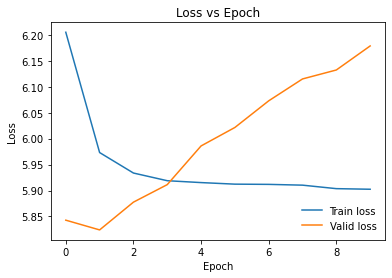

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

# create model and move to gpu if available
rnn = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5)
if train_on_gpu:
    rnn.cuda()

# defining loss and optimization functions for training
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# training the model
trained_rnn, train_losses, valid_losses = train_rnn(
    rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./save/trained_rnn', trained_rnn)
print('Model Trained and Saved')

# Visualize the train/valid loss per epoch
%matplotlib inline
import matplotlib.pyplot as plt

plt.title("Loss vs Epoch")
plt.plot(train_losses, label='Train loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Question: How did you decide on your model hyperparameters? 
For example, did you try different sequence_lengths and find that one size made the model converge faster? What about your hidden_dim and n_layers; how did you decide on those?

**Answer:** 

I completed the following steps:

[X] I experimented with my learning rate

[X] I increased my embedding dimensions

[X] I increased my hidden dimensions

[X] I increased my number of RNN layers by one

[X] I increased the sequence length

[X] I decreased my batch size

[X] I increased my hidden dimension layers

[X] I increased my number of epochs


Initially I've referred hyperparameters from three RNN in the course.

Setiment RNN

embedding_dim = 400
hidden_dim = 256
n_layers = 2
Skip-gram Word2Vec

embedding_dim = 300
learning rate = 0.003
Negative Sampling Solution

embedding_dim = 300
learning rate = 0.003
In my first training, I've started with 'learning rate = 0.003', however, Loss is still gerater than 3.5. And it is observed that Loss is not gradually decreased. So, I tried to smaller 'learning rate = 0.001', and then now, Loss is smaller than 3.5


Going over the course material regarding embedding, I noticed that typical embedding dimensions are around 200 - 300 in size.

Upon reading from different sources:

https://arxiv.org/pdf/1707.06799.pdf
https://github.com/wojzaremba/lstm/blob/76870253cfca069477f06b7056af87f98490b6eb/main.lua#L44
https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/ as well as going over the course examples (Skip-gram Word2Vec, Simple RNN, Sentiment Analysis with an RNN) and onlder courses intuition, I chose the parameters.
I tried:

sequence_length = 10, batch_size = 64, learning_rate = 0.01, embedding_dim = 200, hidden_dim = 200, n_layers = 2. Started with loss 9.25 and after 4 epochs the loss was still around 9.26.
sequence_length = 10, batch_size = 64, learning_rate = 0.003, embedding_dim = 300, hidden_dim = 250, n_layers = 2 Started with Loss: 9.202159190654754 and at epoch 4 it was Loss: 9.206429640371343
sequence_length = 20, batch_size = 20, learning_rate = 0.3, embedding_dim = 300, hidden_dim = 250, n_layers = 2 Started with Loss: 9.70091618013382, and at epoch 4 it was still around 9.6
sequence_length = 20, batch_size = 124, learning_rate = 1, embedding_dim = 200, hidden_dim = 200, n_layers = 2 Started with Epoch: 1/10 Loss: 9.50547212076187 ..
At this point i realized I have some bugs in my code related to zero_grad, extra dropout layer and sigmoid layer. Fixed issues and retried:

sequence_length = 10, batch_size = 128, learning_rate = 0.001, embedding_dim = 200, hidden_dim = 250, n_layers = 2 Started with: Training for 10 epoch(s)... Epoch: 1/10 Loss: 4.944083527803421 ... Epoch: 4/10 Loss: 3.5780555000305174 ... Epoch: 7/10 Loss: 3.3266124720573425 ...

sequence_length = 10, batch_size = 124, learning_rate = 0.1, embedding_dim = 200, hidden_dim = 200, n_layers = 2 Started with Training for 10 epoch(s)... Epoch: 1/10 Loss: 5.481069218158722 Epoch: 2/10 Loss: 5.025624033570289 Epoch: 3/10 Loss: 4.981013494968415

I stopped here, because, even if it was decreasing it seemd to converge way slower than the previous experiment with a lower learning rate and a slightly bigger hidden_dim.

The first experiment above reached: Epoch:   10/10    Loss: 3.1959674040079116.

---
# Checkpoint

After running the above training cell, your model will be saved by name, `trained_rnn`, and if you save your notebook progress, **you can pause here and come back to this code at another time**. You can resume your progress by running the next cell, which will load in our word:id dictionaries _and_ load in your saved model by name!

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch
import helper
import problem_unittests as tests

_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
trained_rnn = helper.load_model('./save/trained_rnn')

## Generate TV Script
With the network trained and saved, you'll use it to generate a new, "fake" Seinfeld TV script in this section.

### Generate Text
To generate the text, the network needs to start with a single word and repeat its predictions until it reaches a set length. You'll be using the `generate` function to do this. It takes a word id to start with, `prime_id`, and generates a set length of text, `predict_len`. Also note that it uses topk sampling to introduce some randomness in choosing the most likely next word, given an output set of word scores!

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
import torch.nn.functional as F

def generate(rnn, prime_id, int_to_vocab, token_dict, pad_value, predict_len=100):
    """
    Generate text using the neural network
    :param decoder: The PyTorch Module that holds the trained neural network
    :param prime_id: The word id to start the first prediction
    :param int_to_vocab: Dict of word id keys to word values
    :param token_dict: Dict of puncuation tokens keys to puncuation values
    :param pad_value: The value used to pad a sequence
    :param predict_len: The length of text to generate
    :return: The generated text
    """
    rnn.eval()
    
    # create a sequence (batch_size=1) with the prime_id
    current_seq = np.full((1, sequence_length), pad_value)
    current_seq[-1][-1] = prime_id
    predicted = [int_to_vocab[prime_id]]
    
    for _ in range(predict_len):
        if train_on_gpu:
            current_seq = torch.LongTensor(current_seq).cuda()
        else:
            current_seq = torch.LongTensor(current_seq)
        
        # initialize the hidden state
        hidden = rnn.init_hidden(current_seq.size(0))
        
        # get the output of the rnn
        output, _ = rnn(current_seq, hidden)
        
        # get the next word probabilities
        p = F.softmax(output, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
         
        # use top_k sampling to get the index of the next word
        top_k = 5
        p, top_i = p.topk(top_k)
        top_i = top_i.numpy().squeeze()
        
        # select the likely next word index with some element of randomness
        p = p.numpy().squeeze()
        word_i = np.random.choice(top_i, p=p/p.sum())
        
        # retrieve that word from the dictionary
        word = int_to_vocab[word_i]
        predicted.append(word)     
        
        if(train_on_gpu):
            current_seq = current_seq.cpu() # move to cpu
        # the generated word becomes the next "current sequence" and the cycle can continue
        if train_on_gpu:
            current_seq = current_seq.cpu()
        current_seq = np.roll(current_seq, -1, 1)
        current_seq[-1][-1] = word_i
    
    gen_sentences = ' '.join(predicted)
    
    # Replace punctuation tokens
    for key, token in token_dict.items():
        ending = ' ' if key in ['\n', '(', '"'] else ''
        gen_sentences = gen_sentences.replace(' ' + token.lower(), key)
    gen_sentences = gen_sentences.replace('\n ', '\n')
    gen_sentences = gen_sentences.replace('( ', '(')
    
    # return all the sentences
    return gen_sentences

### Generate a New Script
It's time to generate the text. Set `gen_length` to the length of TV script you want to generate and set `prime_word` to one of the following to start the prediction:
- "jerry"
- "elaine"
- "george"
- "kramer"

You can set the prime word to _any word_ in our dictionary, but it's best to start with a name for generating a TV script. (You can also start with any other names you find in the original text file!)

In [22]:
# run the cell multiple times to get different results!
gen_length = 400 # modify the length to your preference
prime_word = 'jerry' # name for starting the script

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
pad_word = helper.SPECIAL_WORDS['PADDING']
generated_script = generate(trained_rnn, vocab_to_int[prime_word + ':'], int_to_vocab, token_dict, vocab_to_int[pad_word], gen_length)
print(generated_script)

jerry: oh my
jerry: oh, no!!
george: oh, you have to you know, you have a, i don't you.
jerry: i don't you.
elaine: oh my?
jerry:(. the
elaine: oh.

jerry: i know, a? kramer: i was
kramer: well, and the, the, i was.
jerry:(to his hand up to the the
elaine: what do you know.. george:(.
jerry:()
jerry: well, and i don't you. george: what?


jerry: oh.(to jerry to the
jerry: oh, i know that

jerry: well, the!
jerry: well, and you are you to the, you got that, a?
jerry: what?
jerry: what is that

elaine:(, to jerry)
jerry: what is this
george:() i know.
george:(the. he was to be a? kramer:(the
george:(, the to the the, the!
george: oh no, no! jerry:(to jerry the.. jerry: well. jerry:()
kramer: oh, the?




george: what is a
george: well, i don't you? jerry:(.)
jerry: i think it's like
kramer: i got a? jerry: i was to be. george: i know.() i was a.. jerry: oh, you know what? george: you know.

jerry: oh no, no, no!


jerry: what you got to you got?

elaine:(the) i don't know that
jerry:(the

#### Save your favorite scripts

Once you have a script that you like (or find interesting), save it to a text file!

In [23]:
# save script to a text file
f =  open("generated_script_1.txt","w")
f.write(generated_script)
f.close()

# The TV Script is Not Perfect
It's ok if the TV script doesn't make perfect sense. It should look like alternating lines of dialogue, here is one such example of a few generated lines.

### Example generated script

>jerry: what about me?
>
>jerry: i don't have to wait.
>
>kramer:(to the sales table)
>
>elaine:(to jerry) hey, look at this, i'm a good doctor.
>
>newman:(to elaine) you think i have no idea of this...
>
>elaine: oh, you better take the phone, and he was a little nervous.
>
>kramer:(to the phone) hey, hey, jerry, i don't want to be a little bit.(to kramer and jerry) you can't.
>
>jerry: oh, yeah. i don't even know, i know.
>
>jerry:(to the phone) oh, i know.
>
>kramer:(laughing) you know...(to jerry) you don't know.

You can see that there are multiple characters that say (somewhat) complete sentences, but it doesn't have to be perfect! It takes quite a while to get good results, and often, you'll have to use a smaller vocabulary (and discard uncommon words), or get more data.  The Seinfeld dataset is about 3.4 MB, which is big enough for our purposes; for script generation you'll want more than 1 MB of text, generally. 

# Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_tv_script_generation.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "helper.py" and "problem_unittests.py" files in your submission. Once you download these files, compress them into one zip file for submission.